## test

In [4]:
import numpy as np
import pandas as pd
import torch
# import torch.nn as nn
import matplotlib.pyplot as plt

# from transformers import AdamW
# from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, T5EncoderModel, T5Tokenizer
from tokenizers.pre_tokenizers import Whitespace

pre_tokenizer = Whitespace()

from llmprop_utils import *
import pymatgen
import pymatgen.core.structure 
from matminer.featurizers.site.fingerprint import CrystalNNFingerprint,AGNIFingerprints

from llmprop_model import T5Predictor
# pre-defined functions
# from llmprop_model import T5Predictor
from llmprop_utils import *
from llmprop_dataset import *
from llm_args_parse import *
# set the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
import collections
import re
import os
from pymatgen.core.composition import Composition
from tqdm import tqdm
from collections import OrderedDict

In [6]:

# parse Arguments
args = ArgsParser()
config = args.get_config()

# set parameters
batch_size = config.get('bs')
max_length = config.get('max_len')
learning_rate = config.get('lr')
drop_rate = config.get('dr')
epochs = config.get('epochs')
warmup_steps = config.get('warmup_steps')
preprocessing_strategy = config.get('preprocessing_strategy')
tokenizer_name = config.get('tokenizer')
pooling = config.get('pooling')
scheduler_type = config.get('scheduler')
normalizer_type = config.get('normalizer')
property = config.get('property_name')
optimizer_type = config.get('optimizer')
task_name = config.get('task_name')
train_data_path = config.get('train_data_path')
valid_data_path = config.get('valid_data_path')
test_data_path = config.get('test_data_path')
all_data_path = config.get('all_data_path')

# prepare the data
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)
test_data = pd.read_csv(test_data_path)

all_data = pd.read_csv(all_data_path)

In [5]:
def count_non_zero_lengths(batch_inputs):
    current_length = 0
    for number in batch_inputs:
        if number != 0:
            # 如果当前数字非零，增加当前长度计数
            current_length += 1
    return current_length

d:\deep\GNN\LLM-Prop-main\llmprop_dataset.py:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  featurized_tensor = torch.tensor(featurized_list).float()


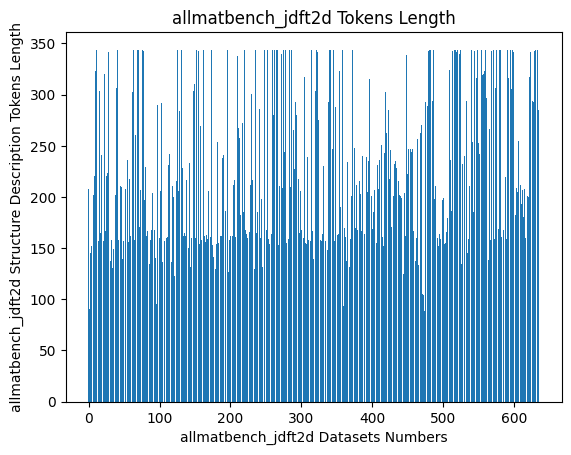

In [6]:
# define the tokenizer
if tokenizer_name == 't5_tokenizer': 
        # tokenizer = AutoTokenizer.from_pretrained("t5-small")
        tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
        # tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

# add defined special tokens to the tokenizer
if pooling == 'cls':
        tokenizer.add_tokens(["[CLS]"])
        
all_dataloader = create_dataloaders(
        tokenizer, 
        all_data, 
        max_length, 
        batch_size, 
        property_value=property, 
        pooling=pooling
    )

inputs_all = []
for batch in all_dataloader:
        batch_inputs, _, _ = tuple(b for b in batch)
        inputs_all.append(batch_inputs)

# 使用列表解析和torch.cat函数对列表中的tensor进行拼接
concatenated_tensor = torch.cat(inputs_all, dim=0)

middle_field = train_data_path.split('/')[1]

count_num = [count_non_zero_lengths(i) for i in concatenated_tensor]
# plt.figure(figsize=(12, 9))  
plt.bar(range(len(count_num)), count_num)
plt.xlabel(f'{middle_field} Datasets Numbers')
plt.ylabel(f'{middle_field} Structure Description Tokens Length')
plt.title(f'{middle_field} Tokens Length')
plt.savefig(f'./plots/{middle_field}_tokens_length_plot.png')
plt.show()

In [7]:
device = torch.device("cuda")

base_model_output_size = 512
base_model = T5EncoderModel.from_pretrained("google/flan-t5-small")
model = T5Predictor(base_model, base_model_output_size, drop_rate=drop_rate, pooling=pooling)
model.to(device)

T5Predictor(
  (embedding_layer): Embedding(32128, 512)
  (encoders): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linea

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

id2label = {0: "metal", 1: "nonmetal"}
tokenizer = AutoTokenizer.from_pretrained("google/MatBERT")
model = AutoModelForSequenceClassification.from_pretrained("google/MatBERT")

description = "BN is Boron Nitride structured and crystallizes in the hexagonal P6_3/mmc space group. B(1) is bonded in a trigonal planar geometry to three equivalent N(1) atoms. All B(1)–N(1) bond lengths are 1.45 Å. N(1) is bonded in a trigonal planar geometry to three equivalent B(1) atoms."
inputs = tokenizer(description, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits
predicted_class = id2label[logits.argmax().item()]
predicted_class

'nonmetal'

In [6]:
class CompositionError(Exception):
    """Exception class for composition errors"""
    pass

def get_sym_dict(f, factor):
    sym_dict = collections.defaultdict(float)
    # compile regex for speedup
    regex = r"([A-Z][a-z]*)\s*([-*\.\d]*)"
    r = re.compile(regex)
    for m in re.finditer(r, f):
        el = m.group(1)
        amt = 1
        if m.group(2).strip() != "":
            amt = float(m.group(2))
        sym_dict[el] += amt * factor
        f = f.replace(m.group(), "", 1)
    if f.strip():
        raise CompositionError(f'{f} is an invalid formula!')
    return sym_dict


def parse_formula(formula):
    '''
    Parameters
    ----------
        formula: str
            A string formula, e.g. Fe2O3, Li3Fe2(PO4)3.
    Return
    ----------
        sym_dict: dict
            A dictionary recording the composition of that formula.
    Notes
    ----------
        In the case of Metallofullerene formula (e.g. Y3N@C80),
        the @ mark will be dropped and passed to parser.
    '''
    # for Metallofullerene like "Y3N@C80"
    formula = formula.replace('@', '')
    formula = formula.replace('[', '(')
    formula = formula.replace(']', ')')
    # compile regex for speedup
    regex = r"\(([^\(\)]+)\)\s*([\.\d]*)"
    r = re.compile(regex)
    m = re.search(r, formula)
    if m:
        factor = 1
        if m.group(2) != "":
            factor = float(m.group(2))
        unit_sym_dict = get_sym_dict(m.group(1), factor)
        expanded_sym = "".join(["{}{}".format(el, amt)
                                for el, amt in unit_sym_dict.items()])
        expanded_formula = formula.replace(m.group(), expanded_sym)
        return parse_formula(expanded_formula)
    sym_dict = get_sym_dict(formula, 1)
    return sym_dict


def _element_composition(formula):
    elmap = parse_formula(formula)
    elamt = {}
    natoms = 0
    for k, v in elmap.items():
        if abs(v) >= 1e-6:
            elamt[k] = v
            natoms += abs(v)
    return elamt

In [22]:
# crabnet

def get_edm(all_data, n_elements=16, verbose=True, scale=True, data_type_torch = torch.float32):
    """
    annotations
    """
    all_symbols = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na',
                    'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc',
                    'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga',
                    'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb',
                    'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                    'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
                    'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
                    'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl',
                    'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
                    'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md',
                    'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg',
                    'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
    
    df = all_data
    df = df.dropna(how='any')
    df['count'] = [len(_element_composition(form)) for form in df['formula']]
    # df = df.groupby(by='formula').mean().reset_index()
    list_ohm = [OrderedDict(_element_composition(form))
                    for form in df['formula']]
    list_ohm = [OrderedDict(sorted(mat.items(), key=lambda x:-x[1]))
                    for mat in list_ohm]
    data_type_np = np.float32
    edm_array = np.zeros(shape=(len(list_ohm),
                                    n_elements,
                                    len(all_symbols)+1),
                            dtype=data_type_np)
    elem_num = np.zeros(shape=(len(list_ohm), n_elements), dtype=data_type_np)
    elem_frac = np.zeros(shape=(len(list_ohm), n_elements), dtype=data_type_np)
    for i, comp in enumerate(tqdm(list_ohm,
                                    desc="Generating EDM",
                                    unit="formulae",
                                    disable=not verbose)):
            for j, (elem, count) in enumerate(list_ohm[i].items()):
                if j == n_elements:
                    # Truncate EDM representation to n_elements
                    break
                try:
                    edm_array[i, j, all_symbols.index(elem) + 1] = count
                    elem_num[i, j] = all_symbols.index(elem) + 1
                except ValueError:
                    print(f'skipping composition {comp}')   
    scale = True
    if scale: 
            # Normalize element fractions within the compound
            for i in range(edm_array.shape[0]):
                frac = (edm_array[i, :, :].sum(axis=-1)
                        / (edm_array[i, :, :].sum(axis=-1)).sum())
                elem_frac[i, :] = frac
    else:
            # Do not normalize element fractions, even for single-element compounds
            for i in range(edm_array.shape[0]):
                frac = edm_array[i, :, :].sum(axis=-1)
                elem_frac[i, :] = frac
    if n_elements == 16:
            n_elements = np.max(np.sum(elem_frac > 0, axis=1, keepdims=True))
            elem_num = elem_num[:, :n_elements]
            elem_frac = elem_frac[:, :n_elements]
    elem_num = elem_num.reshape(elem_num.shape[0], elem_num.shape[1], 1)
    elem_frac = elem_frac.reshape(elem_frac.shape[0], elem_frac.shape[1], 1)
    out = torch.tensor(np.concatenate((elem_num, elem_frac), axis=1))
    src, frac = out.squeeze(-1).chunk(2, dim=1)
    src = src.to(
                dtype=torch.long,
                non_blocking=True)
    frac = frac.to(
                dtype=data_type_torch,
                non_blocking=True)
    mask = frac 
    mask[mask != 0] = 1
    return src,frac,mask

src,frac,mask = get_edm(all_data)

Generating EDM: 100%|██████████| 1265/1265 [00:00<00:00, 105426.40formulae/s]


In [23]:
from encoder_model import Encoder
encoder = Encoder()
x_src = encoder(src, frac)

In [19]:
frac

tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000],
        ...,
        [0.6000, 0.2000, 0.2000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6667, 0.3333, 0.0000, 0.0000, 0.0000]])

In [ ]:
all_data

In [4]:
# 加载T5模型和tokenizer
base_model = T5EncoderModel.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

# create dataloaders
train_dataloader = create_dataloaders(
        tokenizer, 
        train_data, 
        max_length, 
        batch_size, 
        property_value=property, 
        pooling=pooling, 
        normalize=True, 
        normalizer=normalizer_type
    )

for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_masks, batch_labels, batch_norm_labels = tuple(b.to(device) for b in batch)
            input_embedding, predictions = model(batch_inputs, batch_masks )

In [11]:
input_embedding, predictions = model(batch_inputs, batch_masks )

In [8]:


# 加载T5模型和tokenizer
base_model = T5EncoderModel.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

# 获取Embedding层
embedding_layer = base_model.shared

# 构造输入文本
input_text = "Hello, how are you?"
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"]

# 对Embedding层执行forward()操作
embedding_output = embedding_layer(input_ids)



# 对Embedding层执行forward()操作，获取最后一层的输出
with torch.no_grad():
    model_output = base_model(input_ids)

# 获取最后一层的输出
last_hidden_state = model_output.last_hidden_state

print(last_hidden_state.shape)



torch.Size([1, 7, 512])


In [25]:
import torch
from transformers import T5EncoderModel, AutoTokenizer

# 加载T5模型和tokenizer
base_model = T5EncoderModel.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

# 获取Embedding层
embedding_layer = base_model.shared

# 构造输入文本
input_text = "Hello, how are you?"
input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"]

# 对Embedding层执行forward()操作
embedding_output = embedding_layer(input_ids)

# 拼接自定义的embedding features
custom_features = torch.randn(1, 7, 512)  # 假设自定义的embedding features为512维
combined_features = torch.cat((embedding_output, custom_features), dim=1)

# 继续执行base_model后面的网络layers
# outputs = base_model(inputs_embeds=combined_features)
outputs = base_model.encoder(inputs_embeds=combined_features)

# 输出模型的结果
print(outputs)


BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-0.0542, -0.2019, -0.0090,  ..., -0.0026, -0.1892, -0.0932],
         [-0.0707, -0.0110,  0.0484,  ...,  0.2682,  0.0296, -0.0810],
         [-0.0258, -0.1898,  0.0504,  ...,  0.1895, -0.2146, -0.1730],
         ...,
         [ 0.0842,  0.0102, -0.3535,  ..., -0.3378,  0.0366, -0.1812],
         [-0.1450, -0.2351, -0.1390,  ..., -0.1920,  0.2845, -0.1519],
         [ 0.0303,  0.0811, -0.1199,  ..., -0.1470,  0.0234, -0.1669]]],
       grad_fn=<MulBackward0>), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [27]:
base_model

T5EncoderModel(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_fe

In [9]:
blocks = base_model.encoder.block

In [10]:
blocks[0]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=512, out_features=384, bias=False)
        (k): Linear(in_features=512, out_features=384, bias=False)
        (v): Linear(in_features=512, out_features=384, bias=False)
        (o): Linear(in_features=384, out_features=512, bias=False)
        (relative_attention_bias): Embedding(32, 6)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseGatedActDense(
        (wi_0): Linear(in_features=512, out_features=1024, bias=False)
        (wi_1): Linear(in_features=512, out_features=1024, bias=False)
        (wo): Linear(in_features=1024, out_features=512, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): NewGELUActivation()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [12]:
blocks[1]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=512, out_features=384, bias=False)
        (k): Linear(in_features=512, out_features=384, bias=False)
        (v): Linear(in_features=512, out_features=384, bias=False)
        (o): Linear(in_features=384, out_features=512, bias=False)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseGatedActDense(
        (wi_0): Linear(in_features=512, out_features=1024, bias=False)
        (wi_1): Linear(in_features=512, out_features=1024, bias=False)
        (wo): Linear(in_features=1024, out_features=512, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): NewGELUActivation()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [16]:
origin_att = blocks[3].layer[0].SelfAttention
origin_att.config

AttributeError: 'T5Attention' object has no attribute 'config'

In [ ]:
import torch
from torch_scatter import scatter

# 创建一个输入张量
src = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])  # 2个节点，每个节点有4个特征

# 创建一个索引张量，用于指定每个节点的特征应该被聚合到哪里
index = torch.tensor([[0, 0, 1, 1], [0, 1, 1, 0]])  # 每个节点的特征应该被聚合到的目标节点

# 执行scatter操作，将src中的特征按照index指定的规则聚合
out = scatter(src, index, dim=0, reduce='sum')  # 在dim=0维度上按照sum规则聚合

print(out)



tensor([[ 6,  2,  0,  8],
        [ 0,  6, 10,  4]])


In [35]:
input_ids.shape

torch.Size([1, 7])

In [34]:
embedding_output.shape

torch.Size([1, 7, 512])

In [36]:
# 创建一个迭代器
data_iter = iter(all_dataloader)

# 获取下一个批次的数据
batch = next(data_iter)

batch_inputs, batch_masks, batch_labels  = batch
# 在这里，input_data是输入数据，target_data是目标数据
# 您可以根据您的数据结构来访问和处理input_data和target_data


In [78]:
def pymatgen_deserialize_dicts(dicts, to_unit_cell: bool = False):
        s = pymatgen.core.structure.Structure.from_dict(dicts)
        if to_unit_cell:
                for site in s.sites:
                    site.to_unit_cell(in_place=True)
        return s


def featurize_structure(structure, max_atoms):
        CrystalNNFinger = []
        mask = []
        cnnfp = AGNIFingerprints(directions=["x", "y", "z"])
        structure = pymatgen_deserialize_dicts(structure)
        for i in range(len(structure)):
            try:
                sites_feature = np.array(cnnfp.featurize(structure, i))
                mask.append(1)
            except:
                sites_feature = np.zeros((24,))
                mask.append(0)
            CrystalNNFinger.append(sites_feature)
            
        if len(structure) < max_atoms:
            diff = max_atoms - len(structure)
            for i in range(diff):
                CrystalNNFinger.append(np.zeros((24,)))
                mask.append(0)
        return CrystalNNFinger,mask
    
    
def cal_max_atoms(structures):
    structures_pymatgen = [pymatgen_deserialize_dicts(eval(s)) for s in structures]
    max_atoms = max([len(structure) for structure in structures_pymatgen])
    return max_atoms

In [79]:
structures = all_data['structure'].tolist()
max_atoms = cal_max_atoms(structures)
featurized_list = []
mask_list = []
for s in structures:
    fea,mas = featurize_structure(eval(s), max_atoms)
    featurized_list.append(fea)
    mask_list.append(mas)
# featurized_list = [featurize_structure(eval(s), max_atoms)[0] for s in structures]
featurized_tensor = torch.tensor(featurized_list)

In [84]:
torch.tensor(mask_list)[0]

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

torch.Size([636, 35, 24])

In [54]:
structure = pymatgen_deserialize_dicts(eval(structures[9]))
len(structure)

10

In [18]:
import torch
from torch_scatter import scatter

# 创建一个输入张量
src = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])  # 2个节点，每个节点有4个特征

# 创建一个索引张量，用于指定每个节点的特征应该被聚合到哪里
index = torch.tensor([[0, 0, 1, 1], [0, 1, 1, 0]])  # 每个节点的特征应该被聚合到的目标节点

# 执行scatter操作，将src中的特征按照index指定的规则聚合
out = scatter(src, index, dim=0, reduce='sum')  # 在dim=0维度上按照sum规则聚合

print(out)



tensor([[ 6,  2,  0,  8],
        [ 0,  6, 10,  4]])


In [77]:
batch

[tensor([[  784,  8440,   134,   908,     3,   476,   254,    40,   519,    19,
          27042,     3,    17,  3723,   322,  1599,    18,  2376, 14039,    11,
           6884,    40,  1737,     7,    16,     8,  7414, 11005,   447,   205,
          15896,    51,   628,   563,     5,    37,  1809,    19,   192,    18,
          11619,    11,     3,  6848,    13,    80,     3,   476,   254,    40,
            519,  4228,     3,  9442,    16,     8, 17482,     6,  8014,  8925,
           2212,     5,     3,   476, 14296,   519,  1220,    19,     3, 25357,
             12,  1296,  7072,  4779,   599,  4347,  7318,   536,     2,     3,
          10432,     7,    12,   607,  3023,    18, 22473,     3,   476,   254,
             40,   948,     3,    32,    75,    17,     9,    88,  3515,     5,
            432,     3,   476, 14296,    18,   254,    40,   599,  4347,  7318,
           6235,  2475,     7,    33,     3, 22724,  3647,     3,     2,     5,
           4779,   599,  4347,  7318,   

In [75]:
batch_inputs.shape

torch.Size([2, 256])

In [76]:
batch_masks.shape

torch.Size([2, 256])

In [16]:
batch_masks[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
batch_labels.shape

torch.Size([128])

## dft one fold 811

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
name = 'jarvis_dft_3d_dfpt_piezo_max_dielectric'
file_name = 'dfpt_piezo_max_dielectric'

# 读取原始CSV文件
df = pd.read_csv(f'data/{name}/{file_name}.csv')

# 计算分割点
total_data = len(df)
train_size = int(total_data * 0.8)
val_size = int(total_data * 0.1)

# 分割数据集
train_df, test_val_df = train_test_split(df, test_size=(1 - 0.8), random_state=42)

# 进一步分割验证集和测试集，这里我们假设验证集和测试集各占剩余数据的一半
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# 保存分割后的数据集到CSV文件
train_df.to_csv(f'data/{name}/{file_name}_train.csv', index=False)
val_df.to_csv(f'data/{name}/{file_name}_valid.csv', index=False)
test_df.to_csv(f'data/{name}/{file_name}_test.csv', index=False)

print(f"Training set saved with {train_size} rows.")
print(f"Validation set saved with {len(val_df)} rows.")
print(f"Test set saved with {len(test_df)} rows.")

Training set saved with 3763 rows.
Validation set saved with 470 rows.
Test set saved with 471 rows.


## one fold split

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
name = 'allmatbench_log_gvrh'
file_name = 'matbench_log_gvrh'

# 读取原始CSV文件
df = pd.read_csv(f'data/{name}/{file_name}.csv')

# 计算分割点
total_data = len(df)
train_size = int(total_data * 0.86)
val_size = int(total_data * 0.07)

# 分割数据集
train_df, test_val_df = train_test_split(df, test_size=(1 - 0.86), random_state=42)

# 进一步分割验证集和测试集，这里我们假设验证集和测试集各占剩余数据的一半
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# 保存分割后的数据集到CSV文件
train_df.to_csv(f'data/{name}/{file_name}_train.csv', index=False)
val_df.to_csv(f'data/{name}/{file_name}_valid.csv', index=False)
test_df.to_csv(f'data/{name}/{file_name}_test.csv', index=False)

print(f"Training set saved with {train_size} rows.")
print(f"Validation set saved with {len(val_df)} rows.")
print(f"Test set saved with {len(test_df)} rows.")

Training set saved with 9448 rows.
Validation set saved with 769 rows.
Test set saved with 770 rows.


## five fold

In [3]:
import pandas as pd
from sklearn.model_selection import KFold
import os

# 读取原始CSV文件
df = pd.read_csv('matbench_jdft2d.csv')

# 初始化KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建文件夹来保存分割后的CSV文件
output_dir = 'matbench_jdft2d_splits'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 初始化计数器
fold_counter = 1

# 对于每一折
for train_index, val_index in kf.split(df):
    # 创建训练集和验证集的DataFrame
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    # 保存训练集和验证集到CSV文件
    train_file_path = os.path.join(output_dir, f'matbench_jdft2d_train_{fold_counter}.csv')
    val_file_path = os.path.join(output_dir, f'matbench_jdft2d_valid_{fold_counter}.csv')
    
    train_df.to_csv(train_file_path, index=False)
    val_df.to_csv(val_file_path, index=False)

    # 更新计数器
    fold_counter += 1

print("5-fold cross-validation splits have been created and saved to CSV files.")

0.86

## concat

In [11]:
import pandas as pd
import os

# 文件夹路径，假设CSV文件都在这里
# folder_path = 'data/matbench_dielectric/'  # 替换为您的CSV文件所在的文件夹路径
folder_path = 'all/'

# 读取所有CSV文件并将它们合并到一个DataFrame
all_data = pd.DataFrame()

for i in range(3):
    file_name = f'matbench_log_gvrh-{i}.csv'
    file_path = os.path.join(folder_path, file_name)
    
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 如果是第一个文件，保留所有列；否则，只保留指定的列
    if i == 0:
        # 保留所有列
        all_data = df
    else:
        # 只保留指定的列，例如：['index', 'formula', 'structure', 'description', 'n']
        selected_columns = ['index', 'formula', 'structure', 'description', 'log10(G_VRH)']
        df_selected = df[selected_columns]
        all_data = pd.concat([all_data, df_selected], ignore_index=True)
        
# 重新设置index列顺序
all_data.reset_index(drop=True, inplace=True)

# 保存合并后的DataFrame到一个新的CSV文件
merged_file_name = 'matbench_log_gvrh.csv'
all_data.to_csv(merged_file_name, index=False)

print(f'All CSV files have been merged and saved to {merged_file_name}')

All CSV files have been merged and saved to matbench_log_gvrh.csv


In [18]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('data/allmatbench_log_gvrh/matbench_log_gvrh.csv')

# 重置index列
df['index'] = df.index

# 保存到新的CSV文件
df.to_csv('./matbench_log_gvrh_merged.csv', index=False)


## delete the blank row

In [5]:
import pandas as pd
import os
# CSV文件路径
csv_file_path = 'matbench_log_gvrh.csv'
file_path = 'matbench_log_gvrh'
all_path = os.path.join('data/allmatbench_log_gvrh/', csv_file_path)
# 读取CSV文件
df = pd.read_csv(all_path)

# 过滤掉description列包含空白或空字符的行
# 这里使用str.strip()来移除字符串两端的空白字符，然后检查是否为空
# str.contains()用于检查字符串是否包含特定的模式，这里我们检查是否包含任意非空白字符
filtered_df = df[(df['description'].str.strip().str.contains(r'\S', na=False))]

# 保存过滤后的DataFrame到新的CSV文件
filtered_csv_file_path = f'{file_path}_filtered.csv'
save_path = os.path.join(f'data/all{file_path}/', filtered_csv_file_path)
filtered_df.to_csv(save_path, index=False)

print(f"Filtered CSV file saved to {filtered_csv_file_path}")

Filtered CSV file saved to matbench_log_gvrh_filtered.csv
